Script to get the VTA circuits FC directed graph through different levels of TEPS (A and C)

Mu L. July 2024

## Analysis for TEPS

## Section1: important variables p-values

In [594]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind, levene
import pingouin as pg

np.random.seed(12)

In [595]:
def threshold_matrix(matrix, threshold_percentage): # (what for, check the other script when drawing network?)
    
    # Flatten the matrix to array
    flat_matrix = matrix.flatten()
    
    # Get the number of elements in the flattened matrix
    n = flat_matrix.shape[0]
    
    # Sort the flattened matrix in ascending order
    sorted_matrix = np.sort(flat_matrix)
    
    # Choose the location in matrix, the location is the nth * threshold percentage
    threshold_value = sorted_matrix[int(n * threshold_percentage)]
    
    # Create a boolean mask based on the threshold value
    mask = matrix >= threshold_value
    
    # Apply the boolean mask to the matrix to threshold the values
    # >= threshold_value: True and keep, < threshold_value to 0
    thresholded_matrix = np.where(mask, matrix, 0)
    
    # thresholded_matrix = np.where(mask, 1, 0)
    return thresholded_matrix


In [596]:
# add label for improtant variables
import os
import numpy as np
import pandas as pd
import math

def calculateSubjAdj(path_to_data, roi_list_file):
    # Initialize subject_list
    with open('subject_list.txt', 'r') as f:
        subject_ids = [line.strip() for line in f.readlines()]

    # Read ROI names from CSV file
    roi_names_df = pd.read_csv(roi_list_file)
    ROIs2use = roi_names_df['ROI_names'].tolist()

    # Initialize variables: matrix subject numbers * roi numbers
    SLI_all = np.zeros((len(subject_ids), len(ROIs2use)))
    SLD_all = np.zeros((len(subject_ids), len(ROIs2use)))
    important_variable_means = []  # List to store each subject's important_variable_mean matrix
    SubjList = []

    n = 0  # Counter for valid subjects

    for subject_id in subject_ids:
        ts_data_subject = []
        for roi in ROIs2use:
            ts_data_file = f"{subject_id}_{roi}.txt"
            
            # Construct the full path for the file
            ts_data_path = os.path.join(path_to_data, ts_data_file)
        
            # Print the constructed path for debugging
            print(f"Constructed file path: {ts_data_path}")

            if not os.path.exists(ts_data_path):
                print(f"Warning: File {ts_data_file} not found for subject {subject_id}. Skipping.")
                continue

            ts_data = np.loadtxt(ts_data_path)
            # Append all ROI time series data for one subject
            ts_data_subject.append(ts_data)
        
        ROIsTC2use = np.array(ts_data_subject)
        print(f"Subject {subject_id}: ROIsTC2use shape: {ROIsTC2use.shape}")  # ROIsTC2use: (num_ROIs, num_timepoints) for each subject

        if ROIsTC2use.shape[0] == 8:  # Ensure 8 ROIs as rows
            if ROIsTC2use.shape[1] > 100: 
                ROIsTC2use_transpose = ROIsTC2use.transpose()  # (number of time points, number of ROIs)

                df = pd.DataFrame(ROIsTC2use_transpose)
                corrMatrix = df.corr()
                corrMatrix[corrMatrix == 1] = 0.99  # Set the diagonal as 0.99
                np.fill_diagonal(corrMatrix.values, 1)  # Reset diagonal to 1

                R = corrMatrix.values  # Correlation matrix values

                cols = len(ROIs2use)  # Number of ROIs

                # Initialize influencing degree matrix
                important_variable = np.zeros((cols, cols))
                important_variable_std = np.zeros((cols, cols))
                important_variable_mean = np.zeros((cols, cols))
                
                Do_z = 1  # Z-score operation condition
                
                # Calculate the partial correlation coefficients
                for i in range(cols):
                    for j in range(cols):
                        for ind in range(cols):
                            if (ind != i) & (ind != j) & (i != j):
                                corr = (R[i][j] - R[i][ind] * R[j][ind]) / (math.sqrt((1 - R[i][ind] ** 2) * (1 - R[j][ind] ** 2)))
                                if Do_z == 1:
                                    # Fisher's z-transformation
                                    data_z = math.atanh(R[i][j])
                                    corr_z = math.atanh(corr)
                                    diff = data_z - corr_z
                                else:
                                    diff = R[i][j] - corr

                                if diff < 0:
                                    important_variable[j, ind] = 0
                                else:
                                    important_variable[j, ind] = diff

                    # Calculate the mean and std of important variables
                    for t in range(cols):
                        if i != t:
                            temp = important_variable[:, t]
                            important_variable_std[i, t] = np.nanstd(temp)
                            important_variable_mean[i, t] = np.nanmean(temp)
                        else:
                            important_variable_std[i, t] = 0
                            important_variable_mean[i, t] = 0

                np.fill_diagonal(important_variable_mean, 0)
                # Calculate influencing degree: sum of means
                SLI = np.nansum(important_variable_mean, axis=0)  # Sum of each column
                SLI_all[n, :] = SLI  # Store in SLI array
                SLD = np.nansum(important_variable_mean.transpose(), axis=0)
                SLD_all[n, :] = SLD
                important_variable_means.append(important_variable_mean)  # Store each subject's important_variable_mean
                SubjList.append(subject_id)
                n += 1  # For each valid subject

    # Trim excess initialized rows to ensure correct length of valid subjects
    SLI_all = SLI_all[:n, :]
    SLD_all = SLD_all[:n, :]
    SubjList = SubjList[:n]

    # Convert list of important_variable_mean matrices to numpy array
    important_variable_means = np.array(important_variable_means)  # Shape: (num_subjects, num_ROIs, num_ROIs)

    # Flatten the matrix to shape (num_subjects, num_ROIs*num_ROIs)
    num_subjects, num_rois, _ = important_variable_means.shape
    flattened_important_variable_means = important_variable_means.reshape(num_subjects, num_rois * num_rois)

    # Generate ROI labels for the flattened matrix
    roi_labels = [f"{roi1}*{roi2}" for roi1 in ROIs2use for roi2 in ROIs2use]

    return SLI_all, SLD_all, ROIs2use, SubjList, important_variable_means, flattened_important_variable_means, roi_labels

# Define the file paths
FolderPath = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata'
roi_list_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/ROIs_names_K01.csv'

# Calculate subject adjacency matrices for all data
SLI_all_1, SLD_all_1, ROIsLables2use, SubjList, important_variable_means, flattened_important_variable_means, roi_labels = calculateSubjAdj(FolderPath, roi_list_file)

# Influence and dependence
SLI_all = pd.DataFrame(SLI_all_1)
# Set column index as ROIs
SLI_all.columns = ROIsLables2use
SLI_all.insert(0, 'SubjList', SubjList)
# Save to CSV
SLI_all.to_csv('K01_SLI_all_new.csv', index=False)

SLD_all = pd.DataFrame(SLD_all_1)
SLD_all.columns = ROIsLables2use
SLD_all.insert(0, 'SubjList', SubjList)
SLD_all.to_csv('K01_SLD_all_new.csv', index=False)

# Save flattened important variable means
flattened_important_variable_means_df = pd.DataFrame(flattened_important_variable_means, columns=roi_labels)
flattened_important_variable_means_df.insert(0, 'SubjList', SubjList)
flattened_important_variable_means_df.to_csv('K01_Important_Variable_Means_Flattened.csv', index=False)

# Print the shape of important_variable_means for further analysis
print("Shape of important_variable_means:", important_variable_means.shape)
print("Shape of flattened_important_variable_means:", flattened_important_variable_means.shape)


Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/423_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/454_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/454_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/454_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/454_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/454_amyg.txt
Subject 454: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/455_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/455_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_VTA_mni.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/409_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestSta

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/432_amyg.txt
Subject 432: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_rl_accumbens.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_vmPFC2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_dmPFC3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_cg25_2.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_cg_3.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_hipp_thr.txt
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/tsdata/520_amyg.txt
Subject 520: ROIsTC2use shape: (8, 286)
Constructed file path: /Users/limu/Desktop/Lab_work/Laurel_M

Shape of important_variable_means: (79, 8, 8)
Shape of flattened_important_variable_means: (79, 64)


In [597]:
SLI_all

,SubjList,VTA_mni,rl_accumbens,vmPFC2,dmPFC3,cg25_2,cg_3,hipp_thr,amyg
0,434,0.171844,0.285912,1.264411,1.888752,1.211133,1.671565,0.633203,0.258401
1,438,0.032267,0.852487,1.720577,1.985523,1.775997,2.020781,0.980232,0.317823
2,439,0.578919,0.318412,0.653885,0.583128,1.268423,1.478523,1.199589,0.537205
3,440,0.468906,0.833039,2.424447,1.452248,0.542275,1.273139,1.136669,0.679987
4,441,0.015298,0.056517,0.862889,0.045115,0.961808,0.280645,0.646511,0.039143
...,...,...,...,...,...,...,...,...,...
74,531,0.064304,0.114790,1.774883,0.209494,1.503538,1.534426,0.969679,0.282549
75,533,0.222418,0.319003,2.517614,1.023834,1.497306,1.972688,1.845914,0.554192
76,535,0.062526,0.316011,1.526482,0.570681,0.634265,0.956885,0.483218,0.008709
77,536,0.075207,1.708604,2.028073,0.717055,1.962168,1.733164,2.059297,0.715325


In [598]:
# All reordered_important_variable_means
sorted_subjects = sorted(SubjList)
subject_index_all = {subj_id: idx for idx, subj_id in enumerate(SubjList) if subj_id.isdigit()}
all_reordered_important_means = np.array([important_variable_means[subject_index_all[subj_id]] for subj_id in sorted_subjects])

all_reordered_important_means.shape

(79, 8, 8)

In [599]:
# Reorder all covs
# Load the Excel file
excel_file = '/Users/limu/Desktop/Lab_work/Laurel_Morris_Lab/FC_analysis_NewNorm/RestState/DEPNA/Bioinfo.xlsx'
df = pd.read_excel(excel_file)
df['K01_SUBID'] = df['K01_SUBID'].astype(str)

# Reorder data based on common subjects
df = df.set_index('K01_SUBID').reindex(sorted_subjects).reset_index()

print(f"Reordered Data shape: {df.shape}")

df

Reordered Data shape: (79, 26)


,K01_SUBID,MAP_ID,SUB_gende_str,SUB_Age_str,subj,group,SUB_gender_1_F_0_M,SUB_Age,Medication_1_yes_0_no,Daw,...,VTA_mni*cg_3,VTA_mni*hipp_thr,VTA_mni*amyg,rl_accumbens*VTA_mni,vmPFC2*VTA_mni,dmPFC3*VTA_mni,cg25_2*VTA_mni,cg_3*VTA_mni,hipp_thr*VTA_mni,amyg*VTA_mni
0,401,492,M,29,401,0,0,29,0,10,...,0.017325,0.018497,0.003173,0.001329,0.000919,0.000003,0.001015,0.001463,0.001479,0.000715
1,402,759,M,33,402,0,0,33,0,10,...,0.108337,0.440251,0.088607,0.081616,0.076178,0.000000,0.039322,0.044770,0.084621,0.320806
2,406,820,M,35,406,0,0,35,0,10,...,0.238471,0.190204,0.006123,0.035523,0.062389,0.056427,0.057088,0.089402,0.075976,0.018261
3,408,849,F,20,408,0,1,20,0,10,...,0.286773,0.191461,0.002703,0.188631,0.173595,0.159242,0.217117,0.207449,0.174789,0.028700
4,409,910,M,30,409,0,0,30,0,10,...,0.231377,0.419994,0.386639,0.379125,0.327585,0.467464,0.000000,0.250300,0.521093,0.591514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,546,1358,M,32,546,1,0,32,0,5,...,0.059733,0.046227,0.006755,0.016740,0.014156,0.003192,0.002199,0.011732,0.013612,0.006662
75,547,1364,F,24,547,1,1,24,0,5,...,0.000730,0.087153,0.088966,0.018727,0.007108,0.008681,0.004274,0.000188,0.017790,0.025544
76,548,1304,M,30,548,1,0,30,0,5,...,0.047323,0.079637,0.000427,0.023550,0.037226,0.010410,0.004950,0.000000,0.000000,0.004950
77,549,1311,M,25,549,1,0,25,0,5,...,0.060040,0.098011,0.062070,0.020565,0.018589,0.001808,0.020582,0.020383,0.024033,0.034746


TEPSA

In [600]:
import statsmodels.api as sm
import pandas as pd

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsa = []
p_tepsa = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa
}, index=variable_names)

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Display the DataFrame for TEPSA
tepsa_df

,Beta_TEPSA,p_values_TEPSA
VTA_mni*rl_accumbens,-0.001784,0.024124
VTA_mni*vmPFC2,-0.002166,0.058725
VTA_mni*dmPFC3,-0.001881,0.013476
VTA_mni*cg25_2,-0.001525,0.060171
VTA_mni*cg_3,-0.001159,0.373660
VTA_mni*hipp_thr,-0.002430,0.139645
VTA_mni*amyg,-0.001607,0.020522
rl_accumbens*VTA_mni,-0.001114,0.113814
rl_accumbens*vmPFC2,-0.004716,0.006279
rl_accumbens*dmPFC3,-0.001384,0.128309


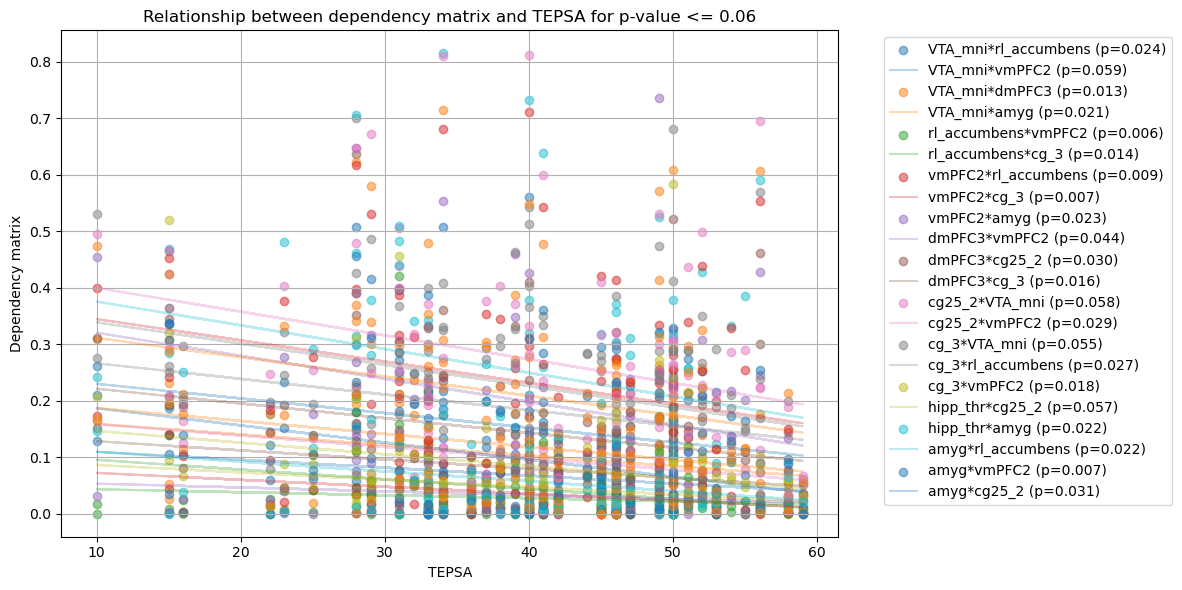

In [601]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
results = []
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa
}, index=variable_names)

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Filter the DataFrame for p-values <= 0.06
significant_tepsa_df = tepsa_df[tepsa_df['p_values_TEPSA'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in significant_tepsa_df.index:
    # Extracting y values for the current ROI
    y_values = sorted_flattened_important_variable_means_df[roi].values
    
    # Plotting the regression line
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  # Scatter plot for each ROI
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA')
plt.ylabel('Dependency matrix')
plt.title('Relationship between dependency matrix and TEPSA for p-value <= 0.06')

# Create legend with ROI names and p-values
legend_labels = [f'{roi} (p={significant_tepsa_df.loc[roi, "p_values_TEPSA"]:.3f})' for roi in significant_tepsa_df.index]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


/var/folders/5b/b9frjt4d2559fjzyzplj3fnm0000gn/T/ipykernel_63438/3975855475.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tepsa_df_vta_mni.loc[:, 'p_values_TEPSA_FDR'] = pvals_corrected


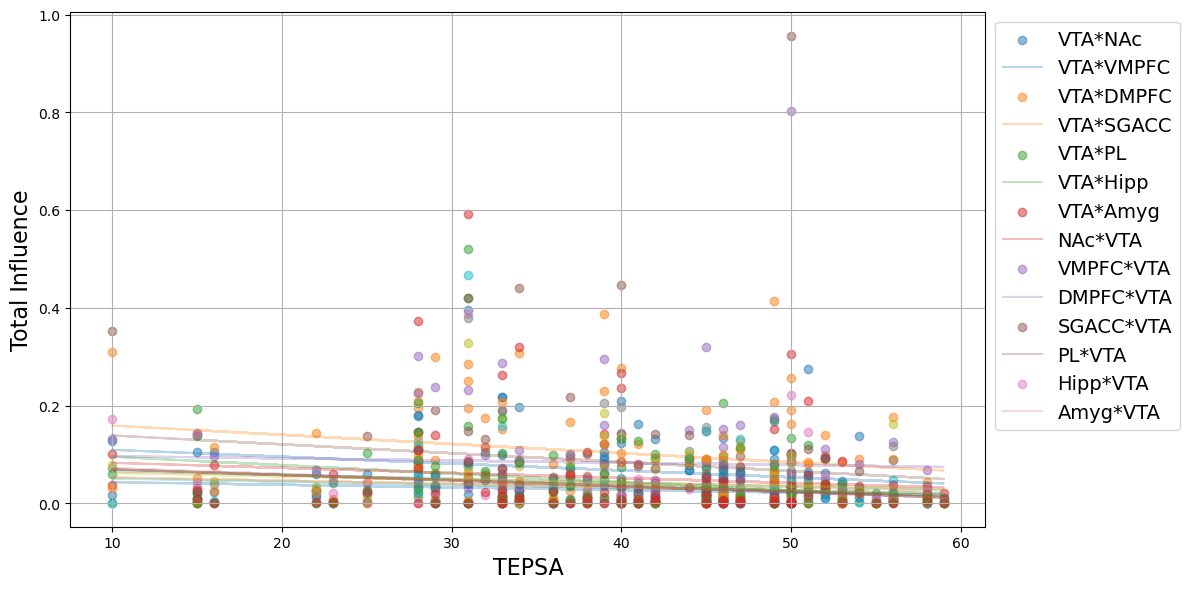

In [602]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mapping of ROI names for plotting
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
results = []
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa,
    'R_squared': r_squared_values
}, index=variable_names)

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Only include variables with 'VTA_mni'
tepsa_df_vta_mni = tepsa_df[tepsa_df.index.str.contains('VTA_mni')]

# FDR correction for p-values of the 'VTA_mni' variables
_, pvals_corrected, _, _ = multipletests(tepsa_df_vta_mni['p_values_TEPSA'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
# .loc avoid warning
tepsa_df_vta_mni.loc[:, 'p_values_TEPSA_FDR'] = pvals_corrected

# Plotting
plt.figure(figsize=(12, 6))

for roi in tepsa_df_vta_mni.index:
    # Extracting y values for the current ROI
    y_values = sorted_flattened_important_variable_means_df[roi].values
    
    # Plotting the regression line
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  # Use the original name in the label
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA', fontsize=16)
plt.ylabel('Total Influence', fontsize=16)
# plt.title('Relationship between dependency matrix and TEPSA for VTA-related ROIs')

# Generate custom labels for the legend
custom_labels = []
for name in tepsa_df_vta_mni.index:
    for old, new in roi_names_mapping.items():
        name = name.replace(old, new)
    custom_labels.append(name)

# Apply the correct legend using custom labels
plt.legend(custom_labels, bbox_to_anchor=(1, 1), loc='upper left', fontsize = 14)

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [603]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Filter for variables containing 'VTA_mni'
vta_mni_indices = [i for i, name in enumerate(variable_names) if 'VTA_mni' in name]

# Initialize lists to store results
results = []
beta_tepsa = []  # Changed variable name
p_tepsa = []     # Changed variable name
r_squared = []   # List to store R-squared values

# Fit the model for each ROI containing 'VTA_mni'
for i in vta_mni_indices:
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA
    r_squared.append(result.rsquared)           # Get R-squared value

# Create a DataFrame to store beta coefficients, p-values, and R-squared for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,               # Changed column name
    'p_values_TEPSA': p_tepsa,               # Changed column name
    'R_squared': r_squared                     # Add R-squared values to the DataFrame
}, index=[variable_names[i] for i in vta_mni_indices])

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Perform FDR correction on the p-values
rejected, p_values_fdr, _, _ = multipletests(tepsa_df['p_values_TEPSA'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
tepsa_df['p_values_TEPSA_FDR'] = p_values_fdr  # Changed column name

# Display the DataFrame for TEPSA
tepsa_df


/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Beta_TEPSA,p_values_TEPSA,R_squared,p_values_TEPSA_FDR
VTA_mni*rl_accumbens,-0.001784,0.024124,0.133909,0.112579
VTA_mni*vmPFC2,-0.002166,0.058725,0.056665,0.120342
VTA_mni*dmPFC3,-0.001881,0.013476,0.095439,0.112579
VTA_mni*cg25_2,-0.001525,0.060171,0.139956,0.120342
VTA_mni*cg_3,-0.001159,0.373660,0.079998,0.373660
VTA_mni*hipp_thr,-0.002430,0.139645,0.037901,0.193754
VTA_mni*amyg,-0.001607,0.020522,0.079218,0.112579
rl_accumbens*VTA_mni,-0.001114,0.113814,0.077296,0.177044
vmPFC2*VTA_mni,-0.000919,0.155345,0.058942,0.193754
dmPFC3*VTA_mni,-0.000881,0.219234,0.044813,0.236098


In [604]:
#tepsa_df_vta_mni.round(3).to_csv('VTA_mni_tepsa_results_FDR_corrected.csv', index=True)
tepsa_df_vta_mni

,Beta_TEPSA,p_values_TEPSA,R_squared,p_values_TEPSA_FDR
VTA_mni*rl_accumbens,-0.001784,0.024124,0.133909,0.112579
VTA_mni*vmPFC2,-0.002166,0.058725,0.056665,0.120342
VTA_mni*dmPFC3,-0.001881,0.013476,0.095439,0.112579
VTA_mni*cg25_2,-0.001525,0.060171,0.139956,0.120342
VTA_mni*cg_3,-0.001159,0.373660,0.079998,0.373660
VTA_mni*hipp_thr,-0.002430,0.139645,0.037901,0.193754
VTA_mni*amyg,-0.001607,0.020522,0.079218,0.112579
rl_accumbens*VTA_mni,-0.001114,0.113814,0.077296,0.177044
vmPFC2*VTA_mni,-0.000919,0.155345,0.058942,0.193754
dmPFC3*VTA_mni,-0.000881,0.219234,0.044813,0.236098


In [605]:
import statsmodels.api as sm
import pandas as pd

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsa = []
p_tepsa = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa
}, index=variable_names)

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Filter for p-values <= 0.06
tepsa_df = tepsa_df[tepsa_df['p_values_TEPSA'] <= 0.06]

# Display the filtered DataFrame for TEPSA
tepsa_df


,Beta_TEPSA,p_values_TEPSA
VTA_mni*rl_accumbens,-0.001784,0.024124
VTA_mni*vmPFC2,-0.002166,0.058725
VTA_mni*dmPFC3,-0.001881,0.013476
VTA_mni*amyg,-0.001607,0.020522
rl_accumbens*vmPFC2,-0.004716,0.006279
rl_accumbens*cg_3,-0.003501,0.014023
vmPFC2*rl_accumbens,-0.002643,0.009032
vmPFC2*cg_3,-0.004431,0.006981
vmPFC2*amyg,-0.001595,0.023037
dmPFC3*vmPFC2,-0.004137,0.044452


In [606]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsa = []
p_tepsa = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa
}, index=variable_names)

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# FDR correction for p-values
tepsa_df['p_values_TEPSA_FDR'] = multipletests(tepsa_df['p_values_TEPSA'], method='fdr_bh')[1]

# Display the DataFrame for TEPSA with FDR-corrected p-values
tepsa_df


,Beta_TEPSA,p_values_TEPSA,p_values_TEPSA_FDR
VTA_mni*rl_accumbens,-0.001784,0.024124,0.102115
VTA_mni*vmPFC2,-0.002166,0.058725,0.146504
VTA_mni*dmPFC3,-0.001881,0.013476,0.102115
VTA_mni*cg25_2,-0.001525,0.060171,0.146504
VTA_mni*cg_3,-0.001159,0.373660,0.418499
VTA_mni*hipp_thr,-0.002430,0.139645,0.211355
VTA_mni*amyg,-0.001607,0.020522,0.102115
rl_accumbens*VTA_mni,-0.001114,0.113814,0.193139
rl_accumbens*vmPFC2,-0.004716,0.006279,0.102115
rl_accumbens*dmPFC3,-0.001384,0.128309,0.205294


In [607]:
import statsmodels.api as sm

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for variables with p-value <= 0.07 for TEPSA
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSA']  # Extract the p-value for TEPSA
    if p_value <= 0.07:
        print(f"Summary for variable {variable_names[i]} (p-value for TEPSA: {p_value}):")
        print(result.summary())
        print("\n")


Summary for variable VTA_mni*rl_accumbens (p-value for TEPSA: 0.024124099291037992):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.257
Date:                Thu, 24 Oct 2024   Prob (F-statistic):             0.0575
Time:                        08:49:11   Log-Likelihood:                 104.10
No. Observations:                  79   AIC:                            -196.2
Df Residuals:                      73   BIC:                            -182.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Summary for variable hipp_thr*cg25_2 (p-value for TEPSA: 0.05718763725511314):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.898
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.105
Time:                        08:49:11   Log-Likelihood:                 51.520
No. Observations:                  79   AIC:                            -91.04
Df Residuals:                      73   BIC:                            -76.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [608]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Filter for variables containing 'VTA_mni'
vta_mni_indices = [i for i, name in enumerate(variable_names) if 'VTA_mni' in name]

# Initialize lists to store results
results = []
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI containing 'VTA_mni'
for i in vta_mni_indices:
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store beta coefficients and p-values for TEPSA
tepsa_df = pd.DataFrame({
    'Beta_TEPSA': beta_tepsa,
    'p_values_TEPSA': p_tepsa
}, index=[variable_names[i] for i in vta_mni_indices])

# Drop rows where Beta_TEPSA is 0 or contain NaN
tepsa_df = tepsa_df[(tepsa_df['Beta_TEPSA'] != 0) & (~tepsa_df['Beta_TEPSA'].isna())]

# Perform FDR correction on the p-values
rejected, p_values_fdr, _, _ = multipletests(tepsa_df['p_values_TEPSA'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
tepsa_df['p_values_TEPSA_FDR'] = p_values_fdr

# Display the DataFrame for TEPSA
tepsa_df


,Beta_TEPSA,p_values_TEPSA,p_values_TEPSA_FDR
VTA_mni*rl_accumbens,-0.001784,0.024124,0.112579
VTA_mni*vmPFC2,-0.002166,0.058725,0.120342
VTA_mni*dmPFC3,-0.001881,0.013476,0.112579
VTA_mni*cg25_2,-0.001525,0.060171,0.120342
VTA_mni*cg_3,-0.001159,0.373660,0.373660
VTA_mni*hipp_thr,-0.002430,0.139645,0.193754
VTA_mni*amyg,-0.001607,0.020522,0.112579
rl_accumbens*VTA_mni,-0.001114,0.113814,0.177044
vmPFC2*VTA_mni,-0.000919,0.155345,0.193754
dmPFC3*VTA_mni,-0.000881,0.219234,0.236098


In [609]:
# export p-values
import statsmodels.api as sm

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSA','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSA
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSA']  # Extract the p-value for TEPSA
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSA: {p_value}")


Variable: VTA_mni*rl_accumbens, p-value for TEPSA: 0.024124099291037992
Variable: VTA_mni*vmPFC2, p-value for TEPSA: 0.05872486498340751
Variable: VTA_mni*dmPFC3, p-value for TEPSA: 0.013475948523542296
Variable: VTA_mni*cg25_2, p-value for TEPSA: 0.06017112869289122
Variable: VTA_mni*amyg, p-value for TEPSA: 0.020522192821737832
Variable: rl_accumbens*vmPFC2, p-value for TEPSA: 0.006278820818977978
Variable: rl_accumbens*cg_3, p-value for TEPSA: 0.014022941144949756
Variable: vmPFC2*rl_accumbens, p-value for TEPSA: 0.009032216626228105
Variable: vmPFC2*cg_3, p-value for TEPSA: 0.0069805291164129965
Variable: vmPFC2*amyg, p-value for TEPSA: 0.02303699317077872
Variable: dmPFC3*vmPFC2, p-value for TEPSA: 0.04445163303005768
Variable: dmPFC3*cg25_2, p-value for TEPSA: 0.029939403435559835
Variable: dmPFC3*cg_3, p-value for TEPSA: 0.015965702316757584
Variable: cg25_2*VTA_mni, p-value for TEPSA: 0.05810548547730389
Variable: cg25_2*vmPFC2, p-value for TEPSA: 0.028831735629302163
Variable:

TEPSC

In [610]:
import statsmodels.api as sm
import pandas as pd

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsc = []
p_tepsc = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc
}, index=variable_names)

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Display the DataFrame for TEPSC
tepsc_df


,Beta_TEPSC,p_values_TEPSC
VTA_mni*rl_accumbens,-0.002724,0.002877
VTA_mni*vmPFC2,-0.001903,0.158109
VTA_mni*dmPFC3,-0.002545,0.004010
VTA_mni*cg25_2,-0.001181,0.216363
VTA_mni*cg_3,-0.001598,0.294166
VTA_mni*hipp_thr,-0.002717,0.158348
VTA_mni*amyg,-0.002309,0.004058
rl_accumbens*VTA_mni,-0.001654,0.043685
rl_accumbens*vmPFC2,-0.005158,0.010878
rl_accumbens*dmPFC3,-0.002069,0.050876


In [611]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsc = []
p_tepsc = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc
}, index=variable_names)

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Perform FDR correction on the p-values
rejected, p_values_fdr, _, _ = multipletests(tepsc_df['p_values_TEPSC'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
tepsc_df['p_values_TEPSC_FDR'] = p_values_fdr

# Display the DataFrame for TEPSC with FDR
tepsc_df


,Beta_TEPSC,p_values_TEPSC,p_values_TEPSC_FDR
VTA_mni*rl_accumbens,-0.002724,0.002877,0.056807
VTA_mni*vmPFC2,-0.001903,0.158109,0.265243
VTA_mni*dmPFC3,-0.002545,0.004010,0.056807
VTA_mni*cg25_2,-0.001181,0.216363,0.318851
VTA_mni*cg_3,-0.001598,0.294166,0.401788
VTA_mni*hipp_thr,-0.002717,0.158348,0.265243
VTA_mni*amyg,-0.002309,0.004058,0.056807
rl_accumbens*VTA_mni,-0.001654,0.043685,0.152898
rl_accumbens*vmPFC2,-0.005158,0.010878,0.073468
rl_accumbens*dmPFC3,-0.002069,0.050876,0.157328


In [612]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
beta_tepsc = []
p_tepsc = []

for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc
}, index=variable_names)

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Perform FDR correction on the p-values
rejected, p_values_fdr, _, _ = multipletests(tepsc_df['p_values_TEPSC'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
tepsc_df['p_values_TEPSC_FDR'] = p_values_fdr

# Filter for p-values <= 0.06
tepsc_filtered_df = tepsc_df[tepsc_df['p_values_TEPSC'] <= 0.06]

# Display the filtered DataFrame for TEPSC
tepsc_filtered_df


,Beta_TEPSC,p_values_TEPSC,p_values_TEPSC_FDR
VTA_mni*rl_accumbens,-0.002724,0.002877,0.056807
VTA_mni*dmPFC3,-0.002545,0.004010,0.056807
VTA_mni*amyg,-0.002309,0.004058,0.056807
rl_accumbens*VTA_mni,-0.001654,0.043685,0.152898
rl_accumbens*vmPFC2,-0.005158,0.010878,0.073468
rl_accumbens*dmPFC3,-0.002069,0.050876,0.157328
rl_accumbens*cg_3,-0.004247,0.010734,0.073468
rl_accumbens*amyg,-0.002514,0.031200,0.145598
vmPFC2*rl_accumbens,-0.004030,0.000534,0.029894
vmPFC2*cg_3,-0.005123,0.007714,0.071995


In [613]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Filter for variables containing 'VTA_mni'
vta_mni_indices = [i for i, name in enumerate(variable_names) if 'VTA_mni' in name]

# Initialize lists to store results
results = []
beta_tepsc = []
p_tepsc = []
r_squared = []

# Fit the model for each ROI containing 'VTA_mni'
for i in vta_mni_indices:
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC
    r_squared.append(result.rsquared)
    
# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc,
    'R_squared': r_squared 
}, index=[variable_names[i] for i in vta_mni_indices])

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Perform FDR correction on the p-values
rejected, p_values_fdr, _, _ = multipletests(tepsc_df['p_values_TEPSC'], method='fdr_bh')

# Add the FDR-corrected p-values to the DataFrame
tepsc_df['p_values_TEPSC_FDR'] = p_values_fdr

# Display the DataFrame for TEPSC
tepsc_df

# tepsc_df.round(3).to_csv('VTA_mni_tepsc_results_FDR_corrected.csv', index=True)

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Beta_TEPSC,p_values_TEPSC,R_squared,p_values_TEPSC_FDR
VTA_mni*rl_accumbens,-0.002724,0.002877,0.178110,0.018936
VTA_mni*vmPFC2,-0.001903,0.158109,0.035872,0.201533
VTA_mni*dmPFC3,-0.002545,0.004010,0.122156,0.018936
VTA_mni*cg25_2,-0.001181,0.216363,0.115849,0.252423
VTA_mni*cg_3,-0.001598,0.294166,0.083911,0.294166
VTA_mni*hipp_thr,-0.002717,0.158348,0.035351,0.201533
VTA_mni*amyg,-0.002309,0.004058,0.115207,0.018936
rl_accumbens*VTA_mni,-0.001654,0.043685,0.097039,0.116836
vmPFC2*VTA_mni,-0.001333,0.077140,0.073178,0.154280
dmPFC3*VTA_mni,-0.001325,0.112959,0.057935,0.175714


In [614]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.003
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.422
Time:                        08:49:12   Log-Likelihood:                 89.567
No. Observations:                  79   AIC:                            -167.1
Df Residuals:                      73   BIC:                            -152.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1224      0.079      1.550      0.126      -0.035       0.280
TEPSC                    -0.0018      0.001     -1.609      0.112      -0.004       0.000
SUB_gender_1_F_0_M       -0.0149      0.020     -0.732      0.467      -0.055       0.026
SUB_Age                  -0.0010      0.001     -0.741      0.461      -0.004       0.002
Medication_1_yes_0_no    -0.0200      0.022     -0.906      0.368      -0.064       0.024
Daw                       0.0017      0.005      0.368      0.714      -0.007       0.011
==============================================================================
Omnibus:                      108.902   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2211.086
Skew:                           4.454   Prob(JB):                         0.00
Kurtosis:                      27.338   Cond. No.                         415.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

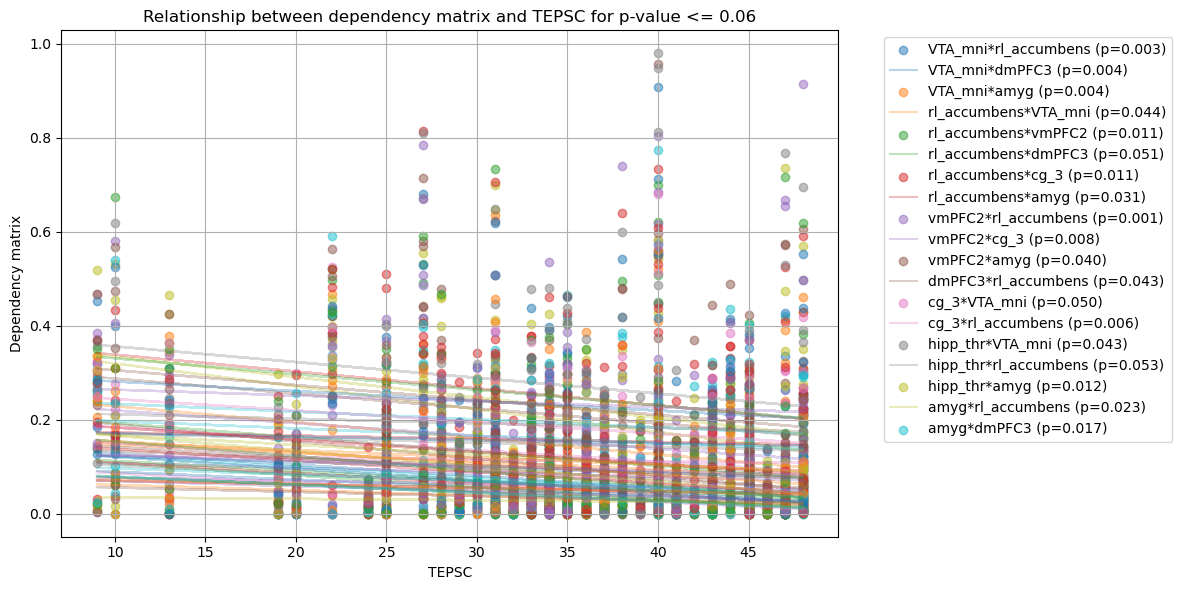

In [615]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
results = []
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc
}, index=variable_names)

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Filter the DataFrame for p-values <= 0.06
# significant_tepsc_df = tepsc_df[tepsc_df['p_values_TEPSC'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in tepsc_df.index:
    # Extracting y values for the current ROI
    y_values = sorted_flattened_important_variable_means_df[roi].values
    
    # Plotting the regression line
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  # Scatter plot for each ROI
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSC')
plt.ylabel('Dependency matrix')
plt.title('Relationship between dependency matrix and TEPSC for p-value <= 0.06')

# Create legend with ROI names and p-values
legend_labels = [f'{roi} (p={significant_tepsc_df.loc[roi, "p_values_TEPSC"]:.3f})' for roi in significant_tepsc_df.index]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


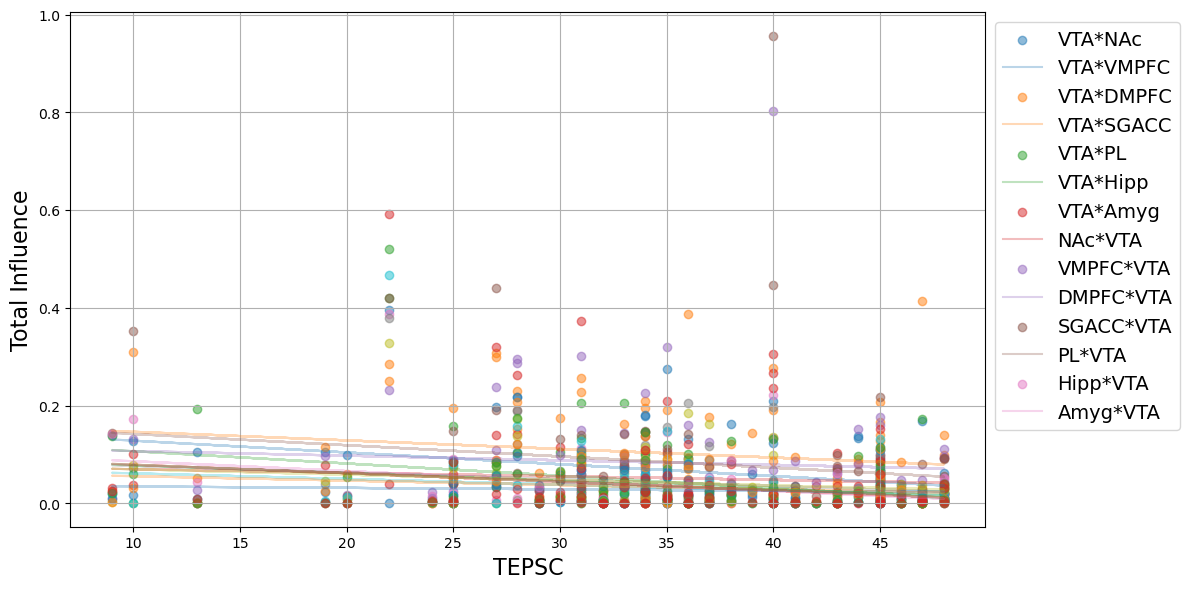

In [616]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mapping of ROI names for plotting
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Initialize lists to store results
results = []
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store beta coefficients and p-values for TEPSC
tepsc_df = pd.DataFrame({
    'Beta_TEPSC': beta_tepsc,
    'p_values_TEPSC': p_tepsc
}, index=variable_names)

# Drop rows where Beta_TEPSC is 0 or contain NaN
tepsc_df = tepsc_df[(tepsc_df['Beta_TEPSC'] != 0) & (~tepsc_df['Beta_TEPSC'].isna())]

# Only include variables with 'VTA_mni'
tepsc_df_vta_mni = tepsc_df[tepsc_df.index.str.contains('VTA_mni')]

# Plotting
plt.figure(figsize=(12, 6))

for roi in tepsc_df_vta_mni.index:
    # Extracting y values for the current ROI
    y_values = sorted_flattened_important_variable_means_df[roi].values
    
    # Plotting the regression line
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  # Use the original name in the label
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSC', fontsize=16)
plt.ylabel('Total Influence', fontsize=16)
# plt.title('Relationship between dependency matrix and TEPSC for VTA-related ROIs')

# Generate custom labels for the legend
custom_labels = []
for name in tepsc_df_vta_mni.index:
    for old, new in roi_names_mapping.items():
        name = name.replace(old, new)
    custom_labels.append(name)

# Apply the correct legend using custom labels
plt.legend(custom_labels, bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [617]:
import statsmodels.api as sm

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
# sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# # (num_subjects, 8, 8) to (num_subjects, 64)
# Y = all_reordered_important_means.reshape(-1, all_reordered_important_means.shape[1] * all_reordered_important_means.shape[2])

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI using variable names
for i, result in enumerate(results):
    print(f"Summary for variable {variable_names[i]}:")
    print(result.summary())
    print("\n")

Summary for variable VTA_mni*VTA_mni:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 24 Oct 2024   Prob (F-statistic):                nan
Time:                        08:49:14   Log-Likelihood:                    inf
No. Observations:                  79   AIC:                              -inf
Df Residuals:                      73   BIC:                              -inf
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid val

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.410
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.231
Time:                        08:49:14   Log-Likelihood:                 26.840
No. Observations:                  79   AIC:                            -41.68
Df Residuals:                      73   BIC:                            -27.46
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.37

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid val

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.240
Date:                Thu, 24 Oct 2024   Prob (F-statistic):             0.0592
Time:                        08:49:15   Log-Likelihood:                 90.669
No. Observations:                  79   AIC:                            -169.3
Df Residuals:                      73   BIC:                            -155.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.08

/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/limu/opt/anaconda3/envs/env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


In [618]:
import statsmodels.api as sm

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for variables with p-value <= 0.07 for TEPSC
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSC']  # Extract the p-value for TEPSC
    if p_value <= 0.07:
        print(f"Summary for variable {variable_names[i]} (p-value for TEPSC: {p_value}):")
        print(result.summary())
        print("\n")


Summary for variable VTA_mni*rl_accumbens (p-value for TEPSC: 0.002876799302274362):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     3.164
Date:                Thu, 24 Oct 2024   Prob (F-statistic):             0.0122
Time:                        08:49:15   Log-Likelihood:                 106.17
No. Observations:                  79   AIC:                            -200.3
Df Residuals:                      73   BIC:                            -186.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.736
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.137
Time:                        08:49:15   Log-Likelihood:                 134.43
No. Observations:                  79   AIC:                            -256.9
Df Residuals:                      73   BIC:                            -242.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.07

In [619]:
# export p-values
import statsmodels.api as sm

# Load and sort the DataFrame
flattened_important_variable_means_df = pd.read_csv('K01_Important_Variable_Means_Flattened.csv')
sorted_flattened_important_variable_means_df = flattened_important_variable_means_df.sort_values(by='SubjList').reset_index(drop=True)

# Prepare the covariates
X = df[['TEPSC','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_flattened_important_variable_means_df.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_flattened_important_variable_means_df.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSC
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSC']  # Extract the p-value for TEPSC
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSC: {p_value}")


Variable: VTA_mni*rl_accumbens, p-value for TEPSC: 0.002876799302274362
Variable: VTA_mni*dmPFC3, p-value for TEPSC: 0.004009641890029487
Variable: VTA_mni*amyg, p-value for TEPSC: 0.004057673648995695
Variable: rl_accumbens*VTA_mni, p-value for TEPSC: 0.043685042038715836
Variable: rl_accumbens*vmPFC2, p-value for TEPSC: 0.010877971819794677
Variable: rl_accumbens*dmPFC3, p-value for TEPSC: 0.05087644275010916
Variable: rl_accumbens*cg_3, p-value for TEPSC: 0.010734053142658578
Variable: rl_accumbens*amyg, p-value for TEPSC: 0.031199523007056945
Variable: vmPFC2*rl_accumbens, p-value for TEPSC: 0.0005338130560171011
Variable: vmPFC2*cg_3, p-value for TEPSC: 0.007713710046560705
Variable: vmPFC2*amyg, p-value for TEPSC: 0.04002797428111981
Variable: dmPFC3*rl_accumbens, p-value for TEPSC: 0.042964383885729734
Variable: cg_3*VTA_mni, p-value for TEPSC: 0.05007252876558477
Variable: cg_3*rl_accumbens, p-value for TEPSC: 0.0060046032811751525
Variable: hipp_thr*VTA_mni, p-value for TEPSC:

## Section2: SLD, SLI all p-values

In [620]:
# reorder SLD and SLI
sorted_SLD = SLD_all.sort_values(by='SubjList').reset_index(drop=True)
sorted_SLI = SLI_all.sort_values(by='SubjList').reset_index(drop=True)

TEPSA

In [621]:
sorted_SLD

,SubjList,VTA_mni,rl_accumbens,vmPFC2,dmPFC3,cg25_2,cg_3,hipp_thr,amyg
0,401,0.074245,0.405629,0.520704,0.235037,0.442510,0.486411,0.537522,0.408185
1,402,1.227657,1.703539,1.517855,2.377899,1.988639,1.978924,1.771518,1.346025
2,406,0.943909,1.257194,1.416808,1.599287,1.564800,1.580745,1.619097,1.321985
3,408,1.217022,1.409199,1.448544,1.397692,1.337393,1.329940,1.397478,0.937622
4,409,2.179023,2.409628,2.306789,2.388652,0.556246,1.844490,2.529260,2.568455
...,...,...,...,...,...,...,...,...,...
74,546,0.245421,0.457988,0.684555,0.800233,0.823936,0.789472,0.595626,0.470890
75,547,0.266296,0.432788,0.504481,0.537315,0.569502,0.559416,0.600402,0.557766
76,548,0.883266,1.193820,1.629234,1.859023,2.128129,1.794264,2.227675,2.108399
77,549,0.443357,0.945110,1.115165,1.027673,1.084909,1.117737,1.029423,0.855047


In [622]:
# TEPSA and sorted_SLD
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSA','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI using variable names
for i, result in enumerate(results):
    print(f"Summary for variable {variable_names[i]}:")
    print(result.summary())
    print("\n")

Summary for variable VTA_mni:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.645
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.159
Time:                        08:49:15   Log-Likelihood:                -44.603
No. Observations:                  79   AIC:                             101.2
Df Residuals:                      73   BIC:                             115.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.292
Date:                Thu, 24 Oct 2024   Prob (F-statistic):             0.0543
Time:                        08:49:15   Log-Likelihood:                -53.538
No. Observations:                  79   AIC:                             119.1
Df Residuals:                      73   BIC:                             133.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.43

In [623]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Perform FDR correction
_, fdr_corrected_p = multipletests(p_tepsa, method='fdr_bh')[:2]

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa,
    'FDR_Corrected_p': fdr_corrected_p
})

# Display the results for TEPSA
results_df


,Variable,Beta_TEPSA,p_value_TEPSA,FDR_Corrected_p
0,VTA_mni,-0.012553,0.015994,0.025591
1,rl_accumbens,-0.016281,0.008323,0.022194
2,vmPFC2,-0.015494,0.005453,0.021810
3,dmPFC3,-0.015411,0.015933,0.025591
4,cg25_2,-0.013032,0.045192,0.046998
5,cg_3,-0.013470,0.029562,0.039416
6,hipp_thr,-0.013624,0.046998,0.046998
7,amyg,-0.016788,0.004319,0.021810


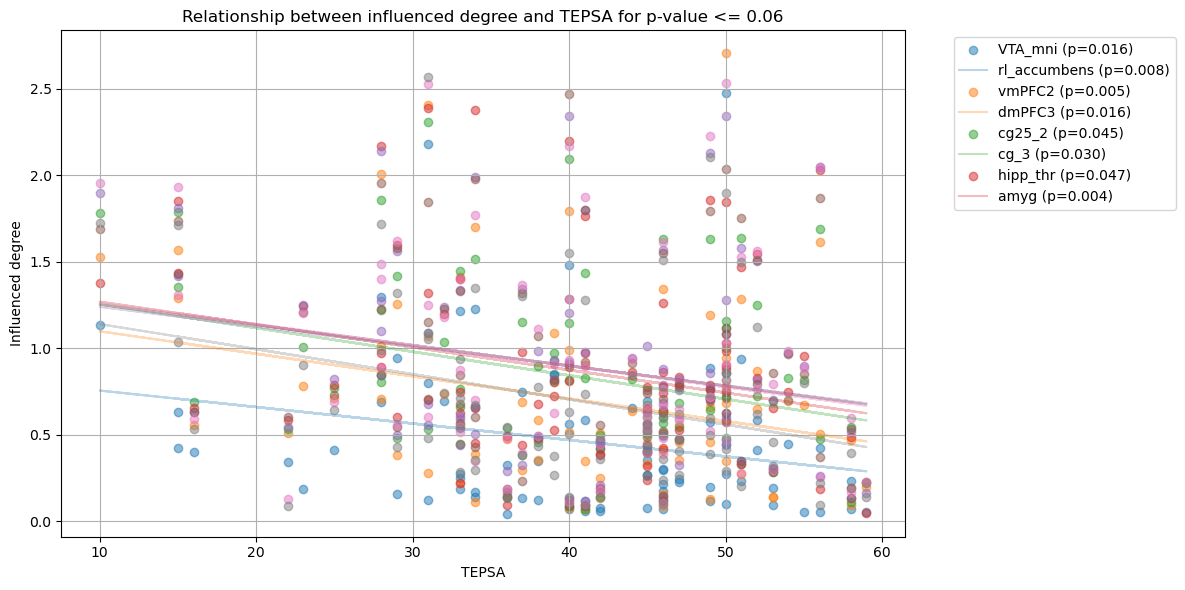

In [624]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSA'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in significant_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLD[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA')
plt.ylabel('Influenced degree')
plt.title('Relationship between influenced degree and TEPSA for p-value <= 0.06')

# Create legend with ROI names
legend_labels = [f'{roi} (p={significant_results_df.loc[significant_results_df["Variable"] == roi, "p_value_TEPSA"].values[0]:.3f})' 
                 for roi in significant_results_df['Variable']]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


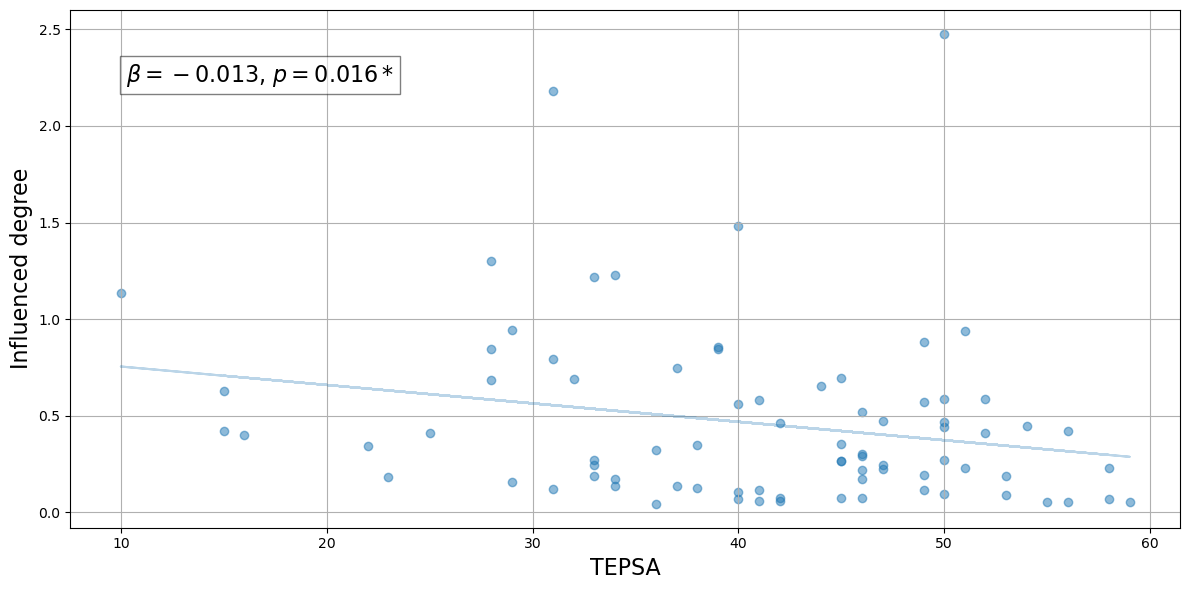

In [625]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ROI name mapping for the legend
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

def get_significance_marker(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
    
# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSA'] <= 0.06]

# Keep only 'VTA_mni' in the results
vta_results_df = significant_results_df[significant_results_df['Variable'] == 'VTA_mni']

# Plotting
plt.figure(figsize=(12, 6))

for roi in vta_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLD[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA',fontsize=16)
plt.ylabel('Influenced degree',fontsize=16)
# plt.title('Relationship between influenced degree and TEPSA for VTA_mni (p-value <= 0.06)')

# Generate custom label for the legend
custom_legend_labels = []
for roi in vta_results_df['Variable']:
    # Replace ROI names based on roi_names_mapping
    custom_label = roi
    for old_name, new_name in roi_names_mapping.items():
        custom_label = custom_label.replace(old_name, new_name)
    
    # Append the label with the corresponding p-value
    p_value = vta_results_df.loc[vta_results_df["Variable"] == roi, "p_value_TEPSA"].values[0]
#     custom_legend_labels.append(f'{custom_label} (p={p_value:.3f})')

significance_marker = get_significance_marker(results_df['p_value_TEPSA'][0])
note_text = f"$β = {results_df['Beta_TEPSA'][0]:.3f}$, $p = {results_df['p_value_TEPSA'][0]:.3f}{significance_marker}$"
ax = plt.gca()
plt.text(0.05, 0.9, note_text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Apply the custom labels to the legend
# plt.legend(custom_legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [626]:
# export p-values
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSA
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSA']  # Extract the p-value for TEPSA
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSA: {p_value}")


Variable: VTA_mni, p-value for TEPSA: 0.015994363735575848
Variable: rl_accumbens, p-value for TEPSA: 0.008322841324642963
Variable: vmPFC2, p-value for TEPSA: 0.005452550027688812
Variable: dmPFC3, p-value for TEPSA: 0.015933398743019654
Variable: cg25_2, p-value for TEPSA: 0.04519223690462689
Variable: cg_3, p-value for TEPSA: 0.0295617706013684
Variable: hipp_thr, p-value for TEPSA: 0.04699779256275424
Variable: amyg, p-value for TEPSA: 0.004318651735851073


In [627]:
# TEPSA and sorted_SLI
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSA','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI using variable names
for i, result in enumerate(results):
    print(f"Summary for variable {variable_names[i]}:")
    print(result.summary())
    print("\n")

Summary for variable VTA_mni:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.294
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.276
Time:                        08:49:16   Log-Likelihood:                -27.383
No. Observations:                  79   AIC:                             66.77
Df Residuals:                      73   BIC:                             80.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [628]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Perform FDR correction
_, fdr_corrected_p = multipletests(p_tepsa, method='fdr_bh')[:2]

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa,
    'FDR_Corrected_p': fdr_corrected_p
})

# Display the results for TEPSA
results_df


,Variable,Beta_TEPSA,p_value_TEPSA,FDR_Corrected_p
0,VTA_mni,-0.007525,0.070043,0.112069
1,rl_accumbens,-0.012683,0.020264,0.077217
2,vmPFC2,-0.026542,0.014376,0.077217
3,dmPFC3,-0.008242,0.189723,0.189723
4,cg25_2,-0.016338,0.038609,0.077217
5,cg_3,-0.021610,0.029589,0.077217
6,hipp_thr,-0.013120,0.136543,0.156049
7,amyg,-0.010594,0.092889,0.123852


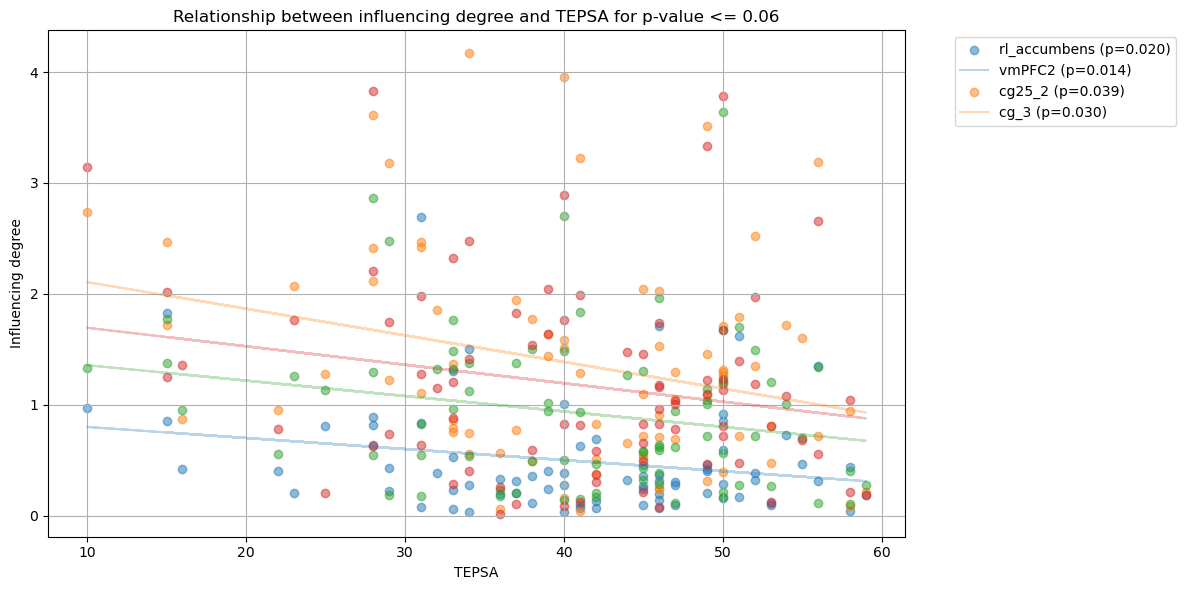

In [629]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSA'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in significant_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLI[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA')
plt.ylabel('Influencing degree')
plt.title('Relationship between influencing degree and TEPSA for p-value <= 0.06')

# Create legend with ROI names
legend_labels = [f'{roi} (p={significant_results_df.loc[significant_results_df["Variable"] == roi, "p_value_TEPSA"].values[0]:.3f})' 
                 for roi in significant_results_df['Variable']]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


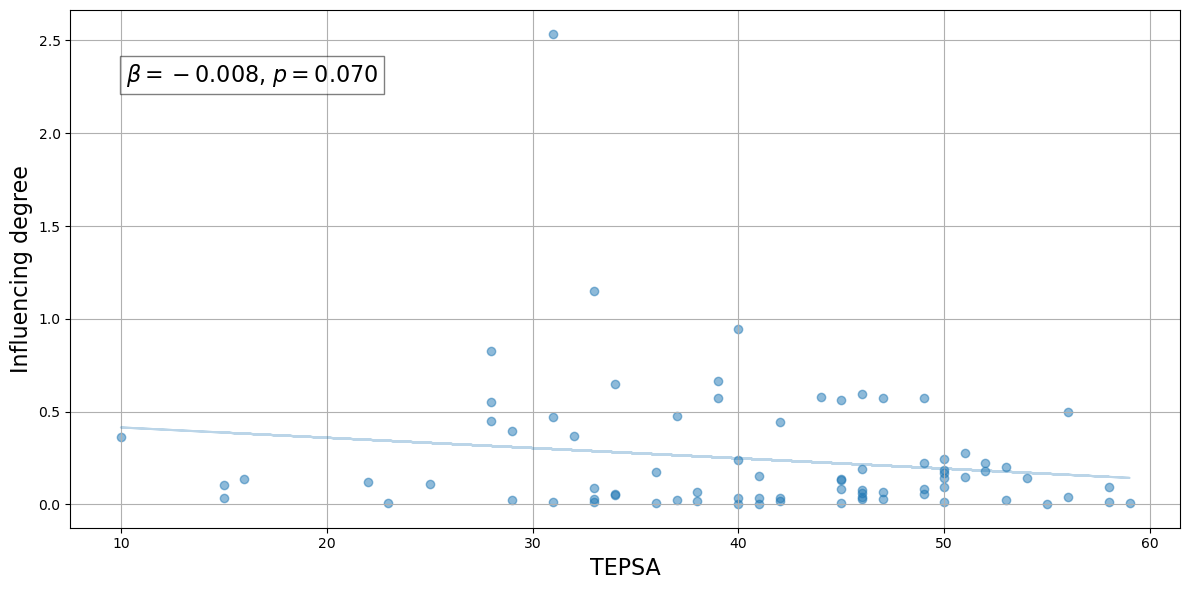

In [630]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ROI name mapping for the legend
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

def get_significance_marker(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
    
# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values 

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]  

# Initialize lists to store beta coefficients and p-values
beta_tepsa = []
p_tepsa = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsa.append(result.params['TEPSA'])  # Get beta coefficient for TEPSA
    p_tepsa.append(result.pvalues['TEPSA'])    # Get p-value for TEPSA

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSA': beta_tepsa,
    'p_value_TEPSA': p_tepsa
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSA'] <= 5]

# Keep only 'VTA_mni' in the results
vta_results_df = significant_results_df[significant_results_df['Variable'] == 'VTA_mni']

# Plotting
plt.figure(figsize=(12, 6))

for roi in vta_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLI[roi].values  
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSA'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSA'], y_values, 1)
    plt.plot(df['TEPSA'], slope * df['TEPSA'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSA', fontsize=16)
plt.ylabel('Influencing degree', fontsize=16)

# Generate custom label for the legend
custom_legend_labels = []
for roi in vta_results_df['Variable']:
    # Replace ROI names based on roi_names_mapping
    custom_label = roi
    for old_name, new_name in roi_names_mapping.items():
        custom_label = custom_label.replace(old_name, new_name)
    
    # Append the label with the corresponding p-value
    p_value = vta_results_df.loc[vta_results_df["Variable"] == roi, "p_value_TEPSA"].values[0]
#     custom_legend_labels.append(f'{custom_label} (p={p_value:.3f})')

significance_marker = get_significance_marker(results_df['p_value_TEPSA'][0])
note_text = f"$β = {results_df['Beta_TEPSA'][0]:.3f}$, $p = {results_df['p_value_TEPSA'][0]:.3f}{significance_marker}$"
ax = plt.gca()
plt.text(0.05, 0.9, note_text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Apply the custom labels to the legend
# plt.legend(custom_legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [631]:
# export p-values
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSA
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSA']  # Extract the p-value for TEPSA
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSA: {p_value}")


Variable: rl_accumbens, p-value for TEPSA: 0.020263579051536768
Variable: vmPFC2, p-value for TEPSA: 0.014376210654698131
Variable: cg25_2, p-value for TEPSA: 0.03860851914365619
Variable: cg_3, p-value for TEPSA: 0.029589387258368918


In [632]:
# TEPSC and sorted_SLD
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSC','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI using variable names
for i, result in enumerate(results):
    print(f"Summary for variable {variable_names[i]}:")
    print(result.summary())
    print("\n")

Summary for variable VTA_mni:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.699
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.146
Time:                        08:49:17   Log-Likelihood:                -44.472
No. Observations:                  79   AIC:                             100.9
Df Residuals:                      73   BIC:                             115.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [633]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Perform FDR correction
_, fdr_corrected_p = multipletests(p_tepsc, method='fdr_bh')[:2]

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,
    'p_value_TEPSC': p_tepsc,
    'FDR_Corrected_p': fdr_corrected_p
})

# Display the results for TEPSC
results_df


,Variable,Beta_TEPSC,p_value_TEPSC,FDR_Corrected_p
0,VTA_mni,-0.014977,0.013948,0.033453
1,rl_accumbens,-0.020100,0.005235,0.033453
2,vmPFC2,-0.016081,0.014249,0.033453
3,dmPFC3,-0.015123,0.044485,0.071176
4,cg25_2,-0.010562,0.168399,0.168399
5,cg_3,-0.012783,0.079272,0.105351
6,hipp_thr,-0.013565,0.092182,0.105351
7,amyg,-0.016604,0.016726,0.033453


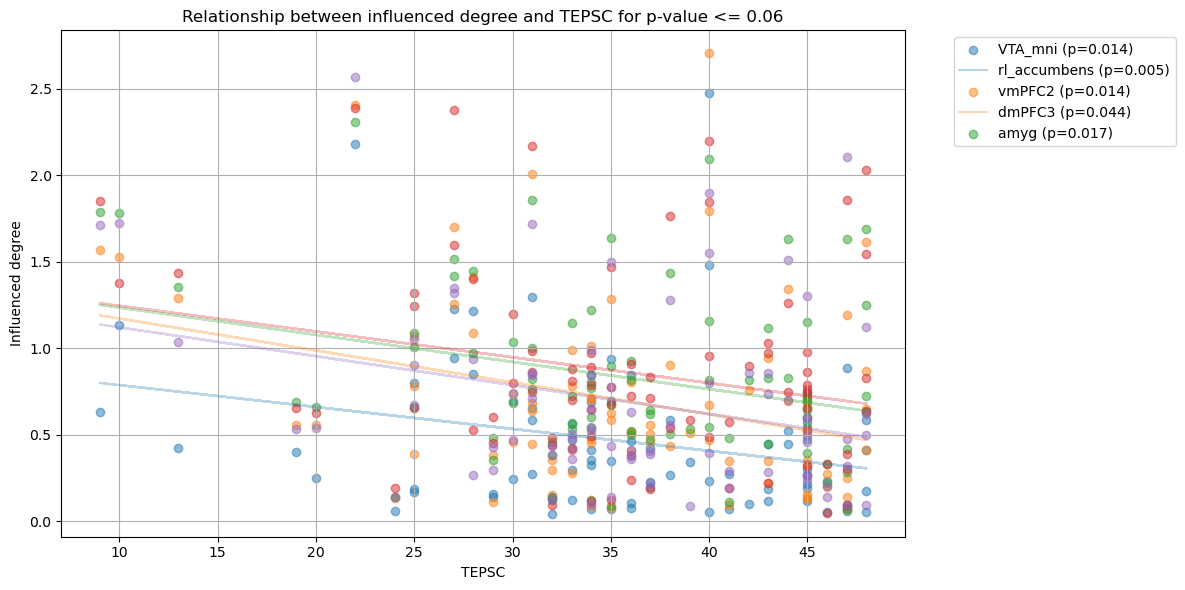

In [634]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,
    'p_value_TEPSC': p_tepsc
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSC'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in significant_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLD[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSC')
plt.ylabel('Influenced degree')
plt.title('Relationship between influenced degree and TEPSC for p-value <= 0.06')

# Create legend with ROI names
legend_labels = [f'{roi} (p={significant_results_df.loc[significant_results_df["Variable"] == roi, "p_value_TEPSC"].values[0]:.3f})' 
                 for roi in significant_results_df['Variable']]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


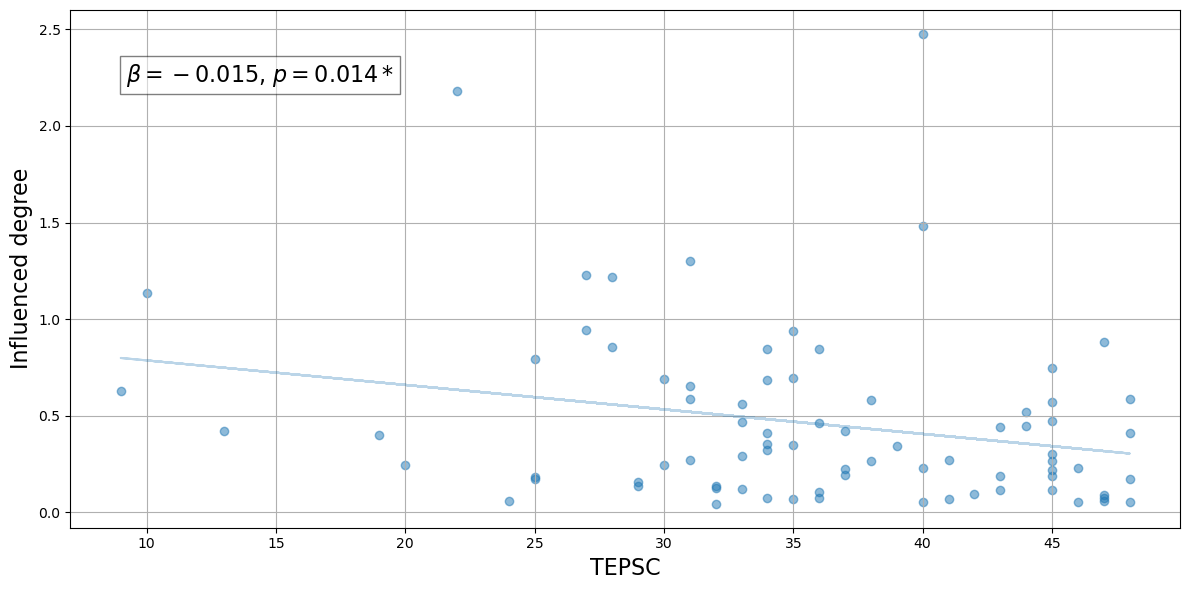

In [635]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ROI name mapping for the legend
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

def get_significance_marker(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
    
# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,
    'p_value_TEPSC': p_tepsc
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSC'] <= 0.06]

# Keep only 'VTA_mni' in the results
vta_results_df = significant_results_df[significant_results_df['Variable'] == 'VTA_mni']

# Plotting
plt.figure(figsize=(12, 6))

for roi in vta_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLD[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSC', fontsize=16)
plt.ylabel('Influenced degree', fontsize=16)
# plt.title('Relationship between influenced degree and TEPSC for VTA_mni (p-value <= 0.06)')

# Generate custom label for the legend
custom_legend_labels = []
for roi in vta_results_df['Variable']:
    # Replace ROI names based on roi_names_mapping
    custom_label = roi
    for old_name, new_name in roi_names_mapping.items():
        custom_label = custom_label.replace(old_name, new_name)
    
    # Append the label with the corresponding p-value
    p_value = vta_results_df.loc[vta_results_df["Variable"] == roi, "p_value_TEPSC"].values[0]
#     custom_legend_labels.append(f'{custom_label} (p={p_value:.3f})')

significance_marker = get_significance_marker(results_df['p_value_TEPSC'][0])
note_text = f"$β = {results_df['Beta_TEPSC'][0]:.3f}$, $p = {results_df['p_value_TEPSC'][0]:.3f}{significance_marker}$"
ax = plt.gca()
plt.text(0.05, 0.9, note_text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Apply the custom labels to the legend
# plt.legend(custom_legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [636]:
# export p-values
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLD.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSC
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSC']  # Extract the p-value for TEPSC
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSC: {p_value}")


Variable: VTA_mni, p-value for TEPSC: 0.013948225766422594
Variable: rl_accumbens, p-value for TEPSC: 0.005235304585522974
Variable: vmPFC2, p-value for TEPSC: 0.014249483391585348
Variable: dmPFC3, p-value for TEPSC: 0.04448499196733716
Variable: amyg, p-value for TEPSC: 0.01672630565481607


In [637]:
# TEPSC and sorted_SLI
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSC','SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print summary for each ROI using variable names
for i, result in enumerate(results):
    print(f"Summary for variable {variable_names[i]}:")
    print(result.summary())
    print("\n")

Summary for variable VTA_mni:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.476
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.208
Time:                        08:49:19   Log-Likelihood:                -26.933
No. Observations:                  79   AIC:                             65.87
Df Residuals:                      73   BIC:                             80.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [638]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Perform FDR correction
_, fdr_corrected_p = multipletests(p_tepsc, method='fdr_bh')[:2]

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,
    'p_value_TEPSC': p_tepsc,
    'FDR_Corrected_p': fdr_corrected_p
})

# Display the results for TEPSC
results_df


,Variable,Beta_TEPSC,p_value_TEPSC,FDR_Corrected_p
0,VTA_mni,-0.009822,0.042686,0.102775
1,rl_accumbens,-0.018051,0.004366,0.034932
2,vmPFC2,-0.018005,0.161592,0.184676
3,dmPFC3,-0.013528,0.064234,0.102775
4,cg25_2,-0.013524,0.146343,0.184676
5,cg_3,-0.021676,0.063326,0.102775
6,hipp_thr,-0.010870,0.293633,0.293633
7,amyg,-0.014319,0.051455,0.102775


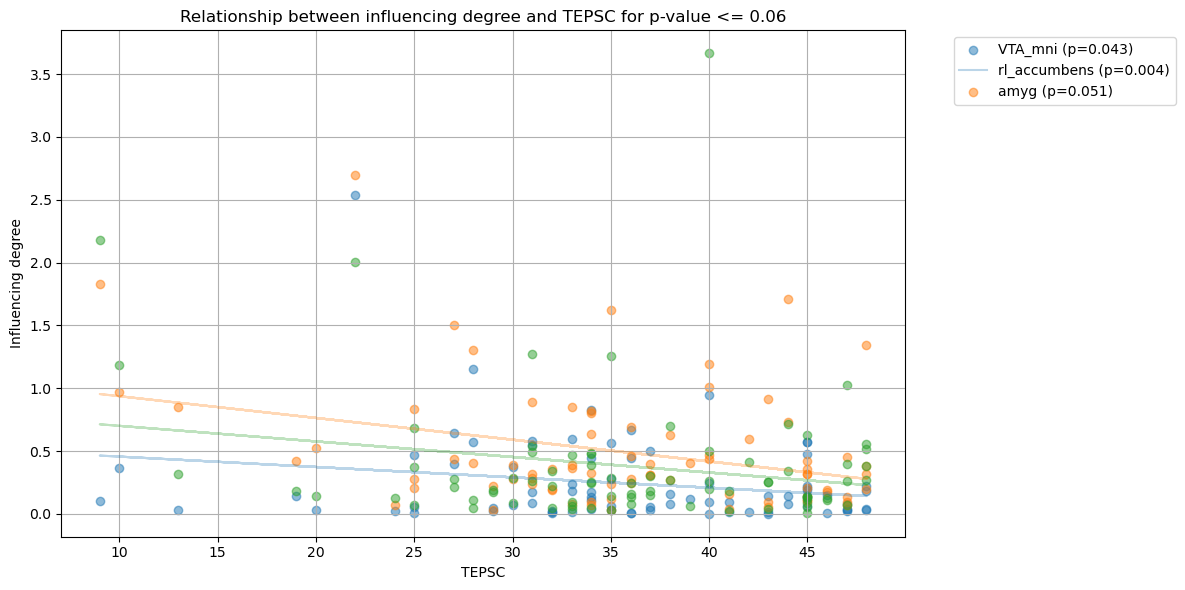

In [639]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []
p_tepsc = []

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,
    'p_value_TEPSC': p_tepsc
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSC'] <= 0.06]

# Plotting
plt.figure(figsize=(12, 6))

for roi in significant_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLI[roi].values
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)

# Labels and title
plt.xlabel('TEPSC')
plt.ylabel('Influencing degree')
plt.title('Relationship between influencing degree and TEPSC for p-value <= 0.06')

# Create legend with ROI names
legend_labels = [f'{roi} (p={significant_results_df.loc[significant_results_df["Variable"] == roi, "p_value_TEPSC"].values[0]:.3f})' 
                 for roi in significant_results_df['Variable']]
plt.legend(legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


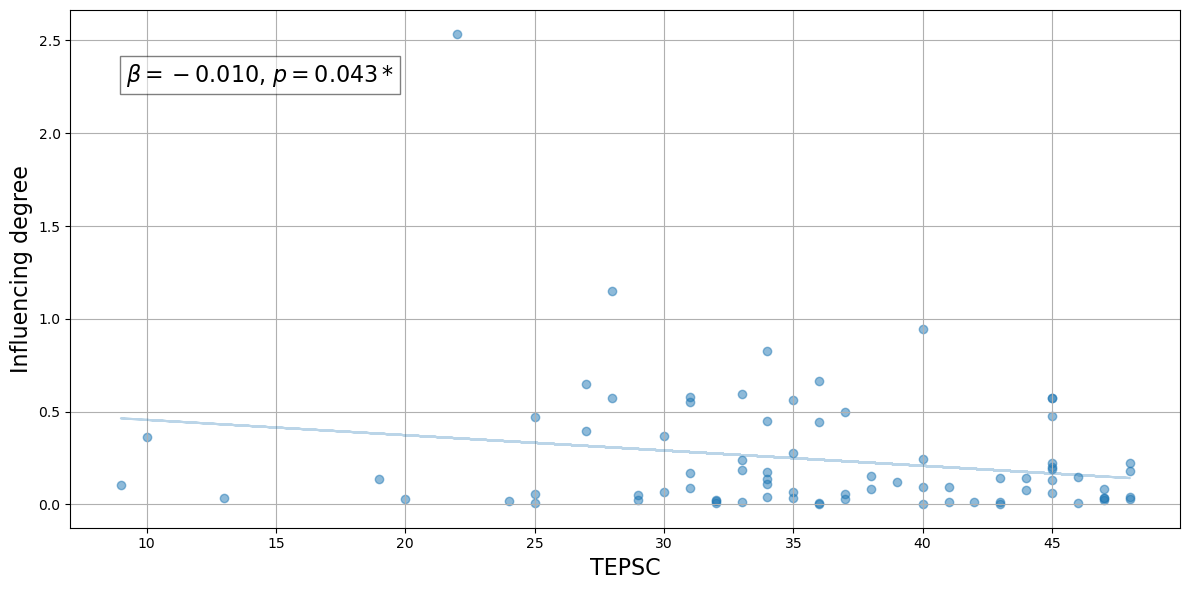

In [640]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ROI name mapping for the legend
roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

def get_significance_marker(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return ''
    
# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values 

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:] 

# Initialize lists to store beta coefficients and p-values
beta_tepsc = []  # Changed variable name
p_tepsc = []    # Changed variable name

# Fit the model for each ROI (or variable in important_variable_means)
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    beta_tepsc.append(result.params['TEPSC'])  # Get beta coefficient for TEPSC
    p_tepsc.append(result.pvalues['TEPSC'])    # Get p-value for TEPSC

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Variable': variable_names,
    'Beta_TEPSC': beta_tepsc,  # Changed variable name
    'p_value_TEPSC': p_tepsc    # Changed variable name
})

# Filter for p-values <= 0.06 (without FDR correction)
significant_results_df = results_df[results_df['p_value_TEPSC'] <= 0.06]  # Changed variable name

# Keep only 'VTA_mni' in the results
vta_results_df = significant_results_df[significant_results_df['Variable'] == 'VTA_mni']

# Plotting
plt.figure(figsize=(12, 6))

for roi in vta_results_df['Variable']:
    # Extracting y values for the current ROI
    y_values = sorted_SLI[roi].values  
    
    # Scatter plot for each ROI
    plt.scatter(df['TEPSC'], y_values, alpha=0.5, label=roi)  
    
    # Fit and plot regression line
    slope, intercept = np.polyfit(df['TEPSC'], y_values, 1)  # Changed variable name
    plt.plot(df['TEPSC'], slope * df['TEPSC'] + intercept, alpha=0.3)  # Changed variable name

# Labels and title
plt.xlabel('TEPSC', fontsize=16)  # Changed variable name
plt.ylabel('Influencing degree', fontsize=16)

# Generate custom label for the legend
custom_legend_labels = []
for roi in vta_results_df['Variable']:
    # Replace ROI names based on roi_names_mapping
    custom_label = roi
    for old_name, new_name in roi_names_mapping.items():
        custom_label = custom_label.replace(old_name, new_name)
    
    # Append the label with the corresponding p-value
    p_value = vta_results_df.loc[vta_results_df["Variable"] == roi, "p_value_TEPSC"].values[0]  # Changed variable name
#     custom_legend_labels.append(f'{custom_label} (p={p_value:.3f})')

significance_marker = get_significance_marker(results_df['p_value_TEPSC'][0])  # Changed variable name
note_text = f"$β = {results_df['Beta_TEPSC'][0]:.3f}$, $p = {results_df['p_value_TEPSC'][0]:.3f}{significance_marker}$"  # Changed variable name
ax = plt.gca()
plt.text(0.05, 0.9, note_text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))

# Apply the custom labels to the legend
# plt.legend(custom_legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid()
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()


In [641]:
# export p-values
import statsmodels.api as sm

# Prepare the covariates
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # Add constant term for intercept

# Extract Y matrix (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# Extract variable names (excluding 'SubjList')
variable_names = sorted_SLI.columns[1:]

# Fit the model for each ROI (or variable in important_variable_means)
results = []
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result)

# Print variable names and p-values for TEPSC
for i, result in enumerate(results):
    p_value = result.pvalues['TEPSC']  # Extract the p-value for TEPSC
    if p_value <= 0.07:
        print(f"Variable: {variable_names[i]}, p-value for TEPSC: {p_value}")


Variable: VTA_mni, p-value for TEPSC: 0.042685796254510834
Variable: rl_accumbens, p-value for TEPSC: 0.004366442052412032
Variable: dmPFC3, p-value for TEPSC: 0.06423434458978883
Variable: cg_3, p-value for TEPSC: 0.06332608496930993
Variable: amyg, p-value for TEPSC: 0.05145493736714161


## DEPNA network

TEPSA

In [642]:
import pandas as pd
import numpy as np

# Extract ROI names from tepsa_df
roi_pairs = tepsa_df.index.tolist()
rois = list(set([pair.split('*')[0] for pair in roi_pairs] + [pair.split('*')[1] for pair in roi_pairs]))
rois.sort()  # Sort ROIs to maintain consistent ordering

# Initialize empty matrices for beta and p-values
beta_matrix = np.zeros((8, 8))
pvalue_matrix = np.zeros((8, 8))

# Fill in the matrices using tepsa_df
for idx, (roi_pair, beta, p_value) in enumerate(zip(roi_pairs, tepsa_df['Beta_TEPSA'], tepsa_df['p_values_TEPSA'])):
    roi1, roi2 = roi_pair.split('*')  # Split the ROI pair
    i = rois.index(roi1)
    j = rois.index(roi2)
    beta_matrix[i, j] = beta
    pvalue_matrix[i, j] = p_value

# Convert the matrices back to DataFrames with ROI names
beta_df = pd.DataFrame(beta_matrix, columns=rois, index=rois)
pvalue_df = pd.DataFrame(pvalue_matrix, columns=rois, index=rois)

# Print the resulting DataFrames
print("Beta Matrix:")
print(beta_df)
print("\nP-Value Matrix:")
print(pvalue_df)


Beta Matrix:
               VTA_mni      amyg    cg25_2      cg_3    dmPFC3  hipp_thr  \
VTA_mni       0.000000 -0.001607 -0.001525 -0.001159 -0.001881  -0.00243   
amyg         -0.001308  0.000000  0.000000  0.000000  0.000000   0.00000   
cg25_2       -0.000856  0.000000  0.000000  0.000000  0.000000   0.00000   
cg_3         -0.001029  0.000000  0.000000  0.000000  0.000000   0.00000   
dmPFC3       -0.000881  0.000000  0.000000  0.000000  0.000000   0.00000   
hipp_thr     -0.001417  0.000000  0.000000  0.000000  0.000000   0.00000   
rl_accumbens -0.001114  0.000000  0.000000  0.000000  0.000000   0.00000   
vmPFC2       -0.000919  0.000000  0.000000  0.000000  0.000000   0.00000   

              rl_accumbens    vmPFC2  
VTA_mni          -0.001784 -0.002166  
amyg              0.000000  0.000000  
cg25_2            0.000000  0.000000  
cg_3              0.000000  0.000000  
dmPFC3            0.000000  0.000000  
hipp_thr          0.000000  0.000000  
rl_accumbens      0.000000  0

In [643]:
import statsmodels.api as sm
import pandas as pd

# 准备协变量
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # 添加截距项

# 提取 Y 矩阵 (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# 提取变量名称 (不包括 'SubjList')
variable_names = sorted_SLI.columns[1:]

# 存储结果的列表
results = []

# 为每个 ROI 拟合模型
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result.params)  # 只保存 beta 系数

# 将 beta 系数结果转换为 DataFrame
SLI_beta_df = pd.DataFrame(results, columns=X.columns, index=variable_names)
SLI_beta_df = SLI_beta_df['TEPSA']
SLI_beta_df

VTA_mni        -0.007525
rl_accumbens   -0.012683
vmPFC2         -0.026542
dmPFC3         -0.008242
cg25_2         -0.016338
cg_3           -0.021610
hipp_thr       -0.013120
amyg           -0.010594
Name: TEPSA, dtype: float64

In [644]:
import statsmodels.api as sm
import pandas as pd

# 准备协变量
X = df[['TEPSA', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # 添加截距项

# 提取 Y 矩阵 (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values  # 将 SLI 替换为 SLD

# 提取变量名称 (不包括 'SubjList')
variable_names = sorted_SLD.columns[1:]  # 将 SLI 替换为 SLD

# 存储结果的列表
results = []

# 为每个 ROI 拟合模型
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result.params)  # 只保存 beta 系数

# 将 beta 系数结果转换为 DataFrame
SLD_beta_df = pd.DataFrame(results, columns=X.columns, index=variable_names)  # 将 SLI 替换为 SLD
SLD_beta_df = SLD_beta_df['TEPSA']  # 将 SLI 替换为 SLD
SLD_beta_df


VTA_mni        -0.012553
rl_accumbens   -0.016281
vmPFC2         -0.015494
dmPFC3         -0.015411
cg25_2         -0.013032
cg_3           -0.013470
hipp_thr       -0.013624
amyg           -0.016788
Name: TEPSA, dtype: float64

In [645]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pdf_file_name = 'output_tepsa_network.pdf'

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]  # Use beta from beta_df
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[i], nodes[j], weight=abs(beta_value), arrow_color=arrow_color)

    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=700, node_color='skyblue', font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [646]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pdf_file_name = 'output_tepsa_network.pdf'

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]  # Use beta from beta_df
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[i], nodes[j], weight=abs(beta_value), arrow_color=arrow_color)

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = beta_values  # Use beta values directly

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    cmap = plt.cm.coolwarm  # Use 'coolwarm' colormap (blue to red)
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

    # Draw the nodes with colors based on beta values
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [647]:
# SLI
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsa_network_SLI.pdf'  

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)
                    # print(abs(beta_value))

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

    # Draw the nodes with colors based on beta values
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

    # Add colorbar as legend for node colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the colorbar

    # Specify the axes to use for the colorbar
    cbar_ax = plt.gca()  # Get the current axes
    cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
    cbar.set_label('Influencing Degree', rotation=270, labelpad=15)

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [648]:
# SLD
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsa_network_SLD.pdf'  

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)

    # Define node colors based on SLD_beta_df
    beta_values = SLD_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

    # Draw the nodes with colors based on beta values
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

    # Add colorbar as legend for node colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the colorbar

    # Specify the axes to use for the colorbar
    cbar_ax = plt.gca()  # Get the current axes
    cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
    cbar.set_label('Influenced Degree', rotation=270, labelpad=15)  # Updated label

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies by Influenced Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [649]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from statsmodels.stats import multitest

pdf_file_name = 'output_tepsa_network.pdf'

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph
    nodes = tepsa_df.index.tolist()  # Use tepsa_df index as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values
    beta_values = tepsa_df['Beta_TEPSA'].values  # Use Beta_TEPSA column
    p_values = tepsa_df['p_values_TEPSA'].values  # Use p_values_TEPSA column

    # FDR correction for p values
    rejected, _, _, _ = multitest.multipletests(p_values, method='fdr_bh')
    
    # Debugging print statements
    print("Rejected hypotheses (FDR):", rejected)

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and rejected[j]:  # Only consider rejected null hypotheses
                beta_value = beta_values[j]  # Use beta as edge weight
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[i], nodes[j], weight=abs(beta_value), arrow_color=arrow_color)

    # Check if any edges were added
    if G.number_of_edges() == 0:
        print("No edges were added to the graph. Check significance levels or data.")
    else:
        pos = nx.circular_layout(G)  # Choose layout algorithm
        edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
        arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

        nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

        # Optionally add labels and other drawing settings
        nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=700, node_color='skyblue', font_color='black', font_size=10)

        plt.title('Directed Graph of Dependencies')  # Set title for the plot
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to free up memory


Rejected hypotheses (FDR): [False False False False False False False False False False False False
 False False]
No edges were added to the graph. Check significance levels or data.


<Figure size 1000x600 with 0 Axes>

tepsc

In [650]:
import pandas as pd
import numpy as np

# Extract ROI names from tepsc_df
roi_pairs = tepsc_df.index.tolist()
rois = list(set([pair.split('*')[0] for pair in roi_pairs] + [pair.split('*')[1] for pair in roi_pairs]))
rois.sort()  # Sort ROIs to maintain consistent ordering

# Initialize empty matrices for beta and p-values
beta_matrix = np.zeros((8, 8))
pvalue_matrix = np.zeros((8, 8))

# Fill in the matrices using tepsc_df
for idx, (roi_pair, beta, p_value) in enumerate(zip(roi_pairs, tepsc_df['Beta_TEPSC'], tepsc_df['p_values_TEPSC'])):
    roi1, roi2 = roi_pair.split('*')  # Split the ROI pair
    i = rois.index(roi1)
    j = rois.index(roi2)
    beta_matrix[i, j] = beta
    pvalue_matrix[i, j] = p_value

# Convert the matrices back to DataFrames with ROI names
beta_df = pd.DataFrame(beta_matrix, columns=rois, index=rois)
pvalue_df = pd.DataFrame(pvalue_matrix, columns=rois, index=rois)

# Print the resulting DataFrames
print("Beta Matrix:")
print(beta_df)
print("\nP-Value Matrix:")
print(pvalue_df)


Beta Matrix:
               VTA_mni      amyg    cg25_2      cg_3    dmPFC3  hipp_thr  \
VTA_mni       0.000000 -0.002309 -0.001181 -0.001598 -0.002545 -0.002717   
amyg         -0.001753  0.000000 -0.002880 -0.001704 -0.002864 -0.002854   
cg25_2       -0.000603 -0.001009  0.000000 -0.003903 -0.001349 -0.000518   
cg_3         -0.001230 -0.001181 -0.001605  0.000000 -0.001821 -0.000662   
dmPFC3       -0.001325 -0.002047 -0.003010 -0.003807  0.000000 -0.000034   
hipp_thr     -0.001924 -0.003566 -0.002506 -0.001293 -0.000947  0.000000   
rl_accumbens -0.001654 -0.002514 -0.001580 -0.004247 -0.002069 -0.002878   
vmPFC2       -0.001333 -0.001691 -0.000763 -0.005123 -0.001934 -0.001207   

              rl_accumbens    vmPFC2  
VTA_mni          -0.002724 -0.001903  
amyg             -0.002488 -0.002061  
cg25_2           -0.001527 -0.001653  
cg_3             -0.002919 -0.003365  
dmPFC3           -0.002032 -0.002867  
hipp_thr         -0.002332 -0.000997  
rl_accumbens      0.000000 -0

In [651]:
import statsmodels.api as sm
import pandas as pd

# 准备协变量，将 'TEPSA' 替换为 'TEPSC'
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # 添加截距项

# 提取 Y 矩阵 (num_subjects, 64)
Y = sorted_SLI.drop(columns='SubjList').values

# 提取变量名称 (不包括 'SubjList')
variable_names = sorted_SLI.columns[1:]

# 存储结果的列表
results = []

# 为每个 ROI 拟合模型
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result.params)  # 只保存 beta 系数

# 将 beta 系数结果转换为 DataFrame
SLI_beta_df = pd.DataFrame(results, columns=X.columns, index=variable_names)

# 选择 'TEPSC' 列
SLI_beta_df = SLI_beta_df['TEPSC']
SLI_beta_df


VTA_mni        -0.009822
rl_accumbens   -0.018051
vmPFC2         -0.018005
dmPFC3         -0.013528
cg25_2         -0.013524
cg_3           -0.021676
hipp_thr       -0.010870
amyg           -0.014319
Name: TEPSC, dtype: float64

In [652]:
import statsmodels.api as sm
import pandas as pd

# 准备协变量，将 'TEPSA' 替换为 'TEPSC'
X = df[['TEPSC', 'SUB_gender_1_F_0_M', 'SUB_Age', 'Medication_1_yes_0_no', 'Daw']]
X = sm.add_constant(X)  # 添加截距项

# 提取 Y 矩阵 (num_subjects, 64)
Y = sorted_SLD.drop(columns='SubjList').values  # 将 SLI 替换为 SLD

# 提取变量名称 (不包括 'SubjList')
variable_names = sorted_SLD.columns[1:]  # 将 SLI 替换为 SLD

# 存储结果的列表
results = []

# 为每个 ROI 拟合模型
for i in range(Y.shape[1]):
    model = sm.OLS(Y[:, i], X)
    result = model.fit()
    results.append(result.params)  # 只保存 beta 系数

# 将 beta 系数结果转换为 DataFrame
SLD_beta_df = pd.DataFrame(results, columns=X.columns, index=variable_names)  # 将 SLI 替换为 SLD

# 选择 'TEPSC' 列
SLD_beta_df = SLD_beta_df['TEPSC']  # 将 SLI 替换为 SLD
SLD_beta_df


VTA_mni        -0.014977
rl_accumbens   -0.020100
vmPFC2         -0.016081
dmPFC3         -0.015123
cg25_2         -0.010562
cg_3           -0.012783
hipp_thr       -0.013565
amyg           -0.016604
Name: TEPSC, dtype: float64

In [653]:
# SLI
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsc_network_SLI.pdf'  

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)
                    # print(abs(beta_value))

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

    # Draw the nodes with colors based on beta values
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

    # Add colorbar as legend for node colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the colorbar

    # Specify the axes to use for the colorbar
    cbar_ax = plt.gca()  # Get the current axes
    cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
    cbar.set_label('Influencing Degree', rotation=270, labelpad=15)

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [654]:
# SLD
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsc_network_SLD.pdf' 

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                beta_value = beta_df.iloc[i, j]
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                    G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)
                    # print(abs(beta_value))

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

    # Draw the nodes with colors based on beta values
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

    # Add colorbar as legend for node colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for the colorbar

    # Specify the axes to use for the colorbar
    cbar_ax = plt.gca()  # Get the current axes
    cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
    cbar.set_label('Influenced Degree', rotation=270, labelpad=15)  

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies by Influenced Degree')  
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [655]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from statsmodels.stats import multitest

pdf_file_name = 'output_tepsc_network.pdf' 

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph
    nodes = tepsc_df.index.tolist() 
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values
    beta_values = tepsc_df['Beta_TEPSC'].values 
    p_values = tepsc_df['p_values_TEPSC'].values 

    # FDR correction for p values
    rejected, _, _, _ = multitest.multipletests(p_values, method='fdr_bh')

    # Debugging print statements
    print("Rejected hypotheses (FDR):", rejected)

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j and rejected[j]:  
                beta_value = beta_values[j]  
                if not np.isnan(beta_value):
                    arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  
                    G.add_edge(nodes[i], nodes[j], weight=abs(beta_value), arrow_color=arrow_color)

    # Check if any edges were added
    if G.number_of_edges() == 0:
        print("No edges were added to the graph. Check significance levels or data.")
    else:
        pos = nx.circular_layout(G)  
        edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]
        arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

        nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

        # Optionally add labels and other drawing settings
        nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=700, node_color='skyblue', font_color='black', font_size=10)

        plt.title('Directed Graph of Dependencies')
        pdf.savefig() 
        plt.close() 


Rejected hypotheses (FDR): [False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


# vta_mni only

In [656]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pdf_file_name = 'output_tepsa_network_vta.pdf'

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            # Check if either node[i] or node[j] is 'VTA_mni' and ensure i != j
            if i != j and (nodes[i] == 'VTA_mni' or nodes[j] == 'VTA_mni'):
                if pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                    beta_value = beta_df.iloc[i, j]  # Use beta from beta_df
                    if not np.isnan(beta_value):
                        arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                        G.add_edge(nodes[], nodes[i], weight=abs(beta_value), arrow_color=arrow_color)

    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=15, width=edge_weights, edge_color=arrow_colors, connectionstyle='arc3,rad=0.1')

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, node_size=700, node_color='skyblue', font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


SyntaxError: invalid syntax (3942783072.py, line 27)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsa_network_vta_SLI.pdf' 

roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            # Check if either node[i] or node[j] is 'VTA_mni' and ensure i != j
            if i != j and (nodes[i] == 'VTA_mni' or nodes[j] == 'VTA_mni'):
                if pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                    beta_value = beta_df.iloc[i, j]
                    if not np.isnan(beta_value):
                        arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                        G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)
    # Draw the nodes with a fixed color (e.g., gray)
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Optionally add labels and other drawing settings
    labels = {node: roi_names_mapping.get(node, node) for node in G.nodes()}  # Map node labels
    nx.draw(G, pos, with_labels=True, labels=labels, font_color='white', font_size=7.2)  # Use the mapped labels

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsc_network_vta_SLI_uncorr.pdf' 

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            # Check if either node[i] or node[j] is 'VTA_mni' and ensure i != j
            if i != j and (nodes[i] == 'VTA_mni' or nodes[j] == 'VTA_mni'):
                if pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                    beta_value = beta_df.iloc[i, j]
                    if not np.isnan(beta_value):
                        arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                        G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)
                        # print(abs(beta_value))

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

#     # Draw the nodes with colors based on beta values
#     node_sizes = 700
#     nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

#     # Add colorbar as legend for node colors
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])  # Dummy array for the colorbar

#     # Specify the axes to use for the colorbar
#     cbar_ax = plt.gca()  # Get the current axes
#     cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
#     cbar.set_label('Influencing Degree', rotation=270, labelpad=15)

    # Optionally add labels and other drawing settings
    nx.draw(G, pos, with_labels=True, labels={node: node for node in G.nodes()}, font_color='black', font_size=10)

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsc_network_vta_SLI_corr.pdf'  

roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            # Check if either node[i] or node[j] is 'VTA_mni' and ensure i != j
            if i != j and (nodes[i] == 'VTA_mni' or nodes[j] == 'VTA_mni'):
                if pvalue_df.iloc[i, j] <= 0.04:  # Use raw p-values to determine significance
                    beta_value = beta_df.iloc[i, j]
                    if not np.isnan(beta_value):
                        arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                        G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)
                        # print(abs(beta_value))

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)

#     # Draw the nodes with colors based on beta values
#     node_sizes = 700
#     nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=rgba_colors)  # Draw nodes with colors

#     # Add colorbar as legend for node colors
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])  # Dummy array for the colorbar

#     # Specify the axes to use for the colorbar
#     cbar_ax = plt.gca()  # Get the current axes
#     cbar = plt.colorbar(sm, ax=cbar_ax)  # Pass the axes to the colorbar
#     cbar.set_label('Influencing Degree', rotation=270, labelpad=15)

    # Draw the nodes with a fixed color (e.g., gray)
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Optionally add labels and other drawing settings
    labels = {node: roi_names_mapping.get(node, node) for node in G.nodes()}  # Map node labels
    nx.draw(G, pos, with_labels=True, labels=labels, font_color='white', font_size=7.2)  # Use the mapped labels

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

pdf_file_name = 'output_tepsc_network_vta_SLI.pdf' 

roi_names_mapping = {
    'VTA_mni': 'VTA',
    'amyg': 'Amyg',
    'rl_accumbens': 'NAc',
    'dmPFC3': 'DMPFC',
    'hipp_thr': 'Hipp',
    'cg_3': 'PL',
    'cg25_2': 'SGACC',
    'vmPFC2': 'VMPFC'
}

with PdfPages(pdf_file_name) as pdf:
    # Create a directed graph
    seed = 12
    G = nx.DiGraph()

    # Add nodes to the graph using the columns of beta_df
    nodes = beta_df.columns.tolist()  # Use ROI names as nodes
    G.add_nodes_from(nodes)
    plt.figure(figsize=(10, 6))

    # Prepare beta and p values from their respective DataFrames
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            # Check if either node[i] or node[j] is 'VTA_mni' and ensure i != j
            if i != j and (nodes[i] == 'VTA_mni' or nodes[j] == 'VTA_mni'):
                if pvalue_df.iloc[i, j] <= 0.05:  # Use raw p-values to determine significance
                    beta_value = beta_df.iloc[i, j]
                    if not np.isnan(beta_value):
                        arrow_color = 'dimgray' if beta_value < 0 else 'lightgray'  # Set color based on beta sign
                        G.add_edge(nodes[j], nodes[i], weight=abs(beta_value)*20, arrow_color=arrow_color)

    # Define node colors based on SLI_beta_df
    beta_values = SLI_beta_df[nodes].values.flatten()  # Ensure order matches nodes
    colorsT = np.abs(beta_values)  # Use absolute beta values for coloring

    # Define custom RGB colormap (Blue -> Green -> Yellow -> Red)
    colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # RGB for blue, green, yellow, red
    cmap = LinearSegmentedColormap.from_list('custom_rgb', colors, N=256)

    # Normalize beta values for coloring (min-max scaling)
    norm = plt.Normalize(colorsT.min(), colorsT.max())  
    rgba_colors = cmap(norm(colorsT))  # Get RGBA colors from the colormap

    # Draw the graph edges
    pos = nx.circular_layout(G)  # Choose layout algorithm
    edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in G.edges()]  # Adjust edge thickness
    arrow_colors = [G[edge[0]][edge[1]]['arrow_color'] for edge in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=1, arrowsize=20, width=edge_weights)
    # Draw the nodes with a fixed color (e.g., gray)
    node_sizes = 700
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Optionally add labels and other drawing settings
    labels = {node: roi_names_mapping.get(node, node) for node in G.nodes()}  # Map node labels
    nx.draw(G, pos, with_labels=True, labels=labels, font_color='white', font_size=7.2)  # Use the mapped labels

    plt.title('Directed Graph of Dependencies by Influencing Degree')  # Set title for the plot
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()  # Close the figure to free up memory
